# Medium Posts Agent

- Gets to know about user interests, like field of interests.
- Recommends (naively) based on interests

In [55]:
from dotenv import load_dotenv

load_dotenv()

import uuid
from langgraph.store.memory import InMemoryStore
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4', temperature=0)
in_memory_store = InMemoryStore()

### Schema definitions

In [56]:
from pydantic import BaseModel, Field
from typing import TypedDict, Literal, Optional
from datetime import datetime


class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in reading about System Design.")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list/array of memories about the user.")

class UpdateMemory(TypedDict):
    """ Decision on what memory type to update """
    update_type: Literal['user', 'publication', 'instructions']


class Publication(BaseModel):
    """Publication to suggest to the user"""
    id: str = Field(description="Id of the publication")
    title: str = Field(description='Title of the Publication')
    summary: str = Field(description='Summary of the article in about 100 words')
    author: str = Field(description='Author Full name')
    url: str = Field(description="Link for the publication")


class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""
    name: Optional[str] = Field(description="The user's name", default=None)
    location: Optional[str] = Field(description="The user's location", default=None)
    job: Optional[str] = Field(description="The user's job", default=None)
    interests: list[str] = Field(
        description="Categories that the user has interest in", 
        default_factory=list
    )
    recommendations: list[Publication] = Field(description='Recommended of Publications based on interests', default=[], max_length=10)



### tools

In [57]:
from langchain_core.tools import tool
import requests

@tool
def get_posts(category: str = None, size: int = 3) -> list[Publication]:
    """Get posts from API based on category"""
    if category is None:
        return [Publication(
            title='Welcome post; Know more about lifestyle, ai, programming, art, finance',
            id='lifestyle-999',
            summary='Sample summary',
            author='Alice',
            url='dummy.com'
        )]

    publications: list[Publication] = requests.get(f"""http://localhost:4001/feed?category={category}""", headers = {'Cache-Control': 'no-cache'}).json()
    return publications[:size]

### System Instructions

#### Router Instruction

In [58]:
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. 

You are designed to be a companion to a user, helping them suggesting medium publications.

You have a long term memory which keeps track of three things:
1. The user's profile (general information about them) 
2. The user's recommended list of medium publications
3. General instructions for updating the Recommended Publications list

Here is the current User Profile (may be empty if no information has been collected yet):
<user_profile>
{user_profile}
</user_profile>

Here is the current Recommended List of Publications (may be empty if no tasks have been added yet):
<publications>
{recommendations}
</publications>

Here are the current user-specified preferences for updating their recommendation list (may be empty if no interests have been specified yet):
<instructions>
{instructions}
</instructions>

Here are your instructions for reasoning about the user's messages:

1. Reason carefully about the user's messages as presented below. 

2. Decide whether any of the your long-term memory should be updated:
- If personal information was provided about the user, update the user's profile by calling UpdateMemory tool with type `user`
- If interests/ publications are mentioned, update the Publication list by calling UpdateMemory tool with type `publication`
- If the user has specified preferences for how to update the Publication list, update the instructions by calling UpdateMemory tool with type `instructions`

3. Tell the user that you have updated your memory, if appropriate:
- Do not tell the user you have updated the user's profile
- Tell the user them when you update the Publication list
- Do not tell the user that you have updated instructions

4. Err on the side of updating the Publication list. No need to ask for explicit permission.

5. Respond naturally to user user after a tool call was made to save memories, or if no tool call was made."""

#### Trustcall instruction

In [59]:
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously.

System Time: {time}"""

#### Publication Create/Update Instruction

In [60]:
CREATE_INSTRUCTIONS = """Reflect on the following interaction.

Based on this interaction, update your instructions for how to update Publication list items. 

Use any feedback from the user to update how they like to have Publication added, etc.

Your current instructions are:

<current_instructions>
{current_instructions}
</current_instructions>"""

### helpers

In [61]:
from trustcall import create_extractor

from langchain_openai import ChatOpenAI


model = ChatOpenAI(model="gpt-4o", temperature=0)

# Inspect the tool calls made by Trustcall
class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):
        # Collect information about the tool calls made by the extractor.
        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                print(r.outputs)
                self.called_tools.append(
                    r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )

# Initialize the spy
spy = Spy()

# Initialize the model
# model = ChatOpenAI(model="gpt-4o", temperature=0)

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

# Add the spy as a listener
trustcall_extractor_see_all_tool_calls = trustcall_extractor.with_listeners(on_end=spy)

def extract_tool_info(tool_calls, schema_name="Memory"):
    """Extract information from tool calls for both patches and new memories.
    
    Args:
        tool_calls: List of tool calls from the model
        schema_name: Name of the schema tool (e.g., "Memory", "Publication", "Profile")
    """

    # Initialize list of changes
    changes = []
    
    for call_group in tool_calls:
        for call in call_group:
            if call['name'] == 'PatchDoc':
                changes.append({
                    'type': 'update',
                    'doc_id': call['args']['json_doc_id'],
                    'planned_edits': call['args']['planned_edits'],
                    'value': call['args']['patches'][0]['value']
                })
            elif call['name'] == schema_name:
                changes.append({
                    'type': 'new',
                    'value': call['args']
                })

    # Format results as a single string
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Added content: {change['value']}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n"
                f"Content: {change['value']}"
            )
    
    return "\n\n".join(result_parts)

# # Inspect spy.called_tools to see exactly what happened during the extraction
# schema_name = "Memory"
# changes = extract_tool_info(spy.called_tools, schema_name)
# print(changes)

### nodes

In [62]:
import uuid
from IPython.display import Image, display

from datetime import datetime
from trustcall import create_extractor
from typing import Optional, Literal
from pydantic import BaseModel, Field

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

#### update profile node

In [63]:
def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("profile", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Profile"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))
    profile_extractor = create_extractor(
        model,
        tools=[Profile],
        tool_choice="Profile",
    )
    # Invoke the extractor
    result = profile_extractor.invoke({"messages": updated_messages, 
                                         "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id":tool_calls[0]['id']}]}

#### Update Publications Node

In [64]:
def update_publication(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("publication", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Publication"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Initialize the spy for visibility into the tool calls made by Trustcall
    spy = Spy()
    
    publication_extractor = create_extractor(
    model,
    tools=[Publication],
    tool_choice=tool_name,
    enable_inserts=True
    ).with_listeners(on_end=spy)

    # Invoke the extractor
    result = publication_extractor.invoke({"messages": updated_messages, 
                                    "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
        
    # Respond to the tool call made in task_mAIstro, confirming the update
    tool_calls = state['messages'][-1].tool_calls

    # Extract the changes made by Trustcall and add the the ToolMessage returned to task_mAIstro
    publication_update_msg = extract_tool_info(spy.called_tools, tool_name)
    return {"messages": [{"role": "tool", "content": publication_update_msg, "tool_call_id":tool_calls[0]['id']}]}

#### Update instructions node

In [65]:
def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]
    
    namespace = ("instructions", user_id)

    existing_memory = store.get(namespace, "user_instructions")
        
    # Format the memory in the system prompt
    system_msg = CREATE_INSTRUCTIONS.format(current_instructions=existing_memory.value if existing_memory else None)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'][:-1] + [HumanMessage(content="Please update the instructions based on the conversation")])

    # Overwrite the existing memory in the store 
    key = "user_instructions"
    store.put(namespace, key, {"memory": new_memory.content})
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated instructions", "tool_call_id":tool_calls[0]['id']}]}

#### main node

In [66]:
def task_mAIstro(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve profile memory from the store
    namespace = ("profile", user_id)
    memories = store.search(namespace)
    if memories:
        user_profile = memories[0].value
    else:
        user_profile = None

    # Retrieve task memory from the store
    namespace = ("publication", user_id)
    memories = store.search(namespace)
    publication = "\n".join(f"{mem.value}" for mem in memories)

    # Retrieve custom instructions
    namespace = ("instructions", user_id)
    memories = store.search(namespace)
    if memories:
        instructions = memories[0].value
    else:
        instructions = ""
    
    system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, recommendations=publication, instructions=instructions)
    # Respond using memory as well as the chat history
    response = model.bind_tools([UpdateMemory], parallel_tool_calls=False).invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": [response]}




### Router/ Conditional Edge

In [67]:
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_publication", "update_instructions", "update_profile"]:

    """Reflect on the memories and chat history to decide whether to update the memory collection."""
    message = state['messages'][-1]
    if len(message.tool_calls) ==0:
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call['args']['update_type'] == "user":
            return "update_profile"
        elif tool_call['args']['update_type'] == "publication":
            return "update_publication"
        elif tool_call['args']['update_type'] == "instructions":
            return "update_instructions"
        else:
            raise ValueError

### Graph

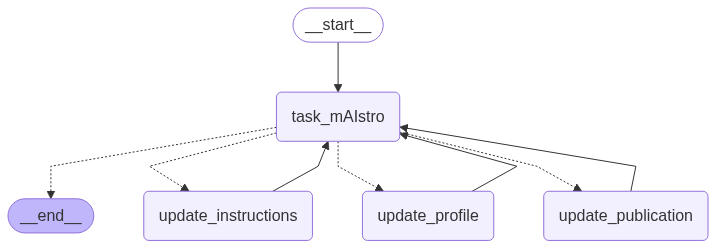

In [68]:
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(task_mAIstro)
builder.add_node(update_publication)
builder.add_node(update_profile)
builder.add_node(update_instructions)
builder.add_edge(START, "task_mAIstro")
builder.add_conditional_edges("task_mAIstro", route_message)
builder.add_edge("update_publication", "task_mAIstro")
builder.add_edge("update_profile", "task_mAIstro")
builder.add_edge("update_instructions", "task_mAIstro")

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [69]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "Alice"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="My name is Alice. I live in NY. I am a Fullstack AI engineer.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My name is Alice. I live in NY. I am a Fullstack AI engineer.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_328Rv7PqxTjUtuTK3aulq9Pz)
 Call ID: call_328Rv7PqxTjUtuTK3aulq9Pz
  Args:
    update_type: user
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

Got it, Alice! If you have any interests or specific topics you'd like recommendations for on Medium, feel free to let me know!


In [74]:
# User input for a ToDo
input_messages = [HumanMessage(content="Would like to know more on Gen AI.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Would like to know more on Gen AI.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_Nric9N8QYDyOXmeFYBydSDIv)
 Call ID: call_Nric9N8QYDyOXmeFYBydSDIv
  Args:
    update_type: publication
{'generations': [[{'text': '', 'generation_info': {'finish_reason': 'stop', 'logprobs': None}, 'type': 'ChatGeneration', 'message': {'lc': 1, 'type': 'constructor', 'id': ['langchain', 'schema', 'messages', 'AIMessage'], 'kwargs': {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_g76lm7LWRbMjOvW8ojkezLNf', 'function': {'arguments': '{"id":"1","title":"The Future of Generative AI: Trends and Predictions","summary":"Explore the latest trends and future predictions in the field of Generative AI. This article delves into the advancements in AI models, their applications across various industries, and the ethical considerations surrounding their u

In [75]:
input_messages = [HumanMessage(content="When updating recommendations, include fullstack oriented")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

When updating recommendations, include fullstack oriented
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_m6svnP4YKRu1bU0fvDGERxHh)
 Call ID: call_m6svnP4YKRu1bU0fvDGERxHh
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

I've updated your preferences to include fullstack-oriented content when recommending publications. If there's anything else you'd like to adjust or add, just let me know!


In [76]:
user_id = "Alice"

# Search 
for memory in across_thread_memory.search(("instructions", user_id)):
    print(memory.value)

{'memory': '<current_instructions>\nWhen updating the Publication list for Alice, include articles related to Generative AI and ensure they have a fullstack orientation. This means focusing on content that not only covers AI concepts but also delves into their implementation and integration within fullstack development environments.\n</current_instructions>'}


In [78]:
input_messages = [HumanMessage(content="Just wondering on building a chatgpt like chat app, what to read?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Just wondering on building a chatgpt like chat app, what to read?
================================== Ai Message ==================================

To get started on building a ChatGPT-like chat app, here are some topics and types of articles you might find useful:

1. **Understanding GPT Models**:
   - Articles explaining how GPT models work, their architecture, and how they generate text.

2. **API Integration**:
   - Guides on integrating AI models like OpenAI's GPT-3 or GPT-4 into applications using APIs.

3. **Frontend Development**:
   - Tutorials on building chat interfaces using frameworks like React, Angular, or Vue.js.

4. **Backend Development**:
   - Articles on setting up a server to handle requests, using Node.js, Django, or Flask.

5. **Real-time Communication**:
   - Resources on implementing real-time chat features using WebSockets or libraries like Socket.io.

6. **User Authentication**:

In [79]:
# User input to update an existing ToDo
input_messages = [HumanMessage(content="For the recom, I;d like it to be on python and react")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

For the recom, I;d like it to be on python and react
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_nHCy93TZSElZfstEH6uxk5Hu)
 Call ID: call_nHCy93TZSElZfstEH6uxk5Hu
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

I've updated your preferences to include recommendations that focus on Python and React, especially in the context of building fullstack applications. If there's anything else you'd like to adjust or add, just let me know!


In [81]:
user_id = "Alice"

# Search 
for memory in across_thread_memory.search(("publication", user_id)):
    print(memory.value)

{'id': '1', 'title': 'The Future of Generative AI: Trends and Predictions', 'summary': 'Explore the latest trends and future predictions in the field of Generative AI. This article delves into the advancements in AI models, their applications across various industries, and the ethical considerations surrounding their use. Stay ahead in the AI game by understanding where Generative AI is headed.', 'author': 'Dr. Emily Carter', 'url': 'https://medium.com/future-of-ai/the-future-of-generative-ai-trends-and-predictions-123456789'}


In [82]:
config = {"configurable": {"thread_id": "2", "user_id": "Alice"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="I have all day to read")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I have all day to read
================================== Ai Message ==================================

That's great! Since you have some time to read, would you like me to suggest some Medium publications based on your interests or any specific topics you're curious about?


In [84]:
input_messages = [HumanMessage(content="Sure, les go for RAG apps")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Sure, les go for RAG apps
================================== Ai Message ==================================

I'll update your preferences to include recommendations related to Retrieval-Augmented Generation (RAG) applications. Let me find some relevant publications for you.
Tool Calls:
  UpdateMemory (call_q0P9O2uViuSgrf9vfOh4fn6M)
 Call ID: call_q0P9O2uViuSgrf9vfOh4fn6M
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

I've updated your preferences to include a focus on Retrieval-Augmented Generation (RAG) applications. Let me find some relevant publications for you. 

Here is a publication you might find interesting:

- **Title:** The Future of Generative AI: Trends and Predictions
  - **Summary:** Explore the latest trends and future

In [86]:
config = {"configurable": {"thread_id": "2", "user_id": "Alice"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="Curios what to invest in Robinhood, what caN read to get some knowledge")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Curios what to invest in Robinhood, what caN read to get some knowledge
================================== Ai Message ==================================

To gain knowledge about investing on Robinhood, you might want to explore articles that cover investment strategies, market analysis, and tips for using the Robinhood platform effectively. Let me find some relevant Medium publications for you.
Tool Calls:
  UpdateMemory (call_BxCgCtoCVZfartEykpvwJ9op)
 Call ID: call_BxCgCtoCVZfartEykpvwJ9op
  Args:
    update_type: publication
{'generations': [[{'text': '', 'generation_info': {'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ChatGeneration', 'message': {'lc': 1, 'type': 'constructor', 'id': ['langchain', 'schema', 'messages', 'AIMessage'], 'kwargs': {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_GMftQJPGtIkqY8dEORiaBS3u', 'function': {'arguments': '{"id": "2", "title": "Inves